# `dtreeviz` Spark Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_spark_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use Spark and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q pyspark

In [3]:
import pandas as pd
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.regression import DecisionTreeRegressor, DecisionTreeRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType


import dtreeviz

random_state = 1234 # get reproducible trees

In [4]:
spark_version = int(pyspark.__version__.split(".")[0])
print(f"Tested versions are 2 and 3, yours is {spark_version}.")

Tested versions are 2 and 3, yours is 3.


## Load Sample Data

In [5]:
spark = SparkSession.builder \
            .master("local[2]") \
            .appName("dtreeviz_sparkml") \
            .getOrCreate()

22/12/22 15:12:38 WARN Utils: Your hostname, beast.local resolves to a loopback address: 127.0.0.1; using 192.168.0.106 instead (on interface en0)
22/12/22 15:12:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/22 15:12:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)

df_schema = StructType([StructField("PassengerId",IntegerType(),True),
                StructField("Survived",IntegerType(),True),
                StructField("Pclass",IntegerType(),True),
                StructField("Name",StringType(),True),
                StructField("Sex",StringType(),True),
                StructField("Age",DoubleType(),True),
                StructField("SibSp",IntegerType(),True),
                StructField("Parch",IntegerType(),True),
                StructField("Ticket",StringType(),True),
                StructField("Fare",DoubleType(),True),
                StructField("Cabin",StringType(),True),
                StructField("Embarked",StringType(),True)])

data = spark.createDataFrame(dataset, df_schema)

In [7]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|  NaN|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|  NaN|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|  NaN|       S|
|          6|       0|     3|    Moran, Mr. James|  male| NaN|    0|    0|      

In [8]:
sex_label_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_label", handleInvalid="keep")
embarked_label_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_label", handleInvalid="keep")
age_imputer = Imputer(inputCols=["Age"], outputCols=["Age"])


# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [9]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age", "SibSp", "Parch", "Fare"]
target = "Survived"

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="Survived", maxDepth=4, seed=1234)
pipeline = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer, vector_assembler, decision_tree])
model = pipeline.fit(data)

## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [10]:
# extract from the pipeline the tree model classifier
tree_model_classifier = model.stages[4]

# recompute the dataset on which the model was trained 
dataset = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer]) \
    .fit(data) \
    .transform(data) \
    .toPandas()[features + [target]]

In [11]:
viz_model = dtreeviz.model(tree_model_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["survive", "perish"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.

## Tree structure visualizations


To show the decision tree structure using the default visualization, call `view()`:

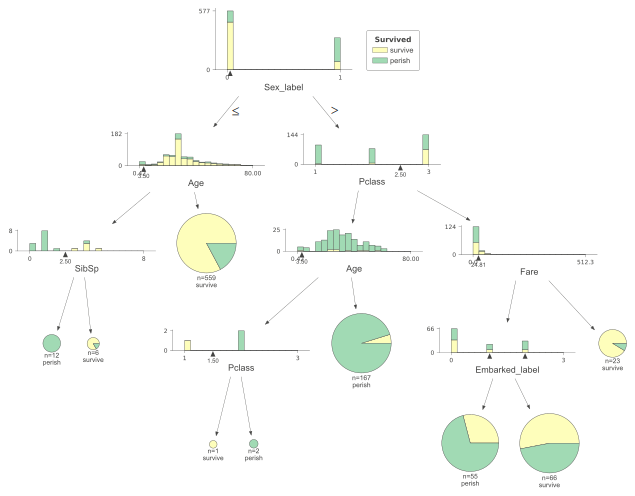

In [12]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

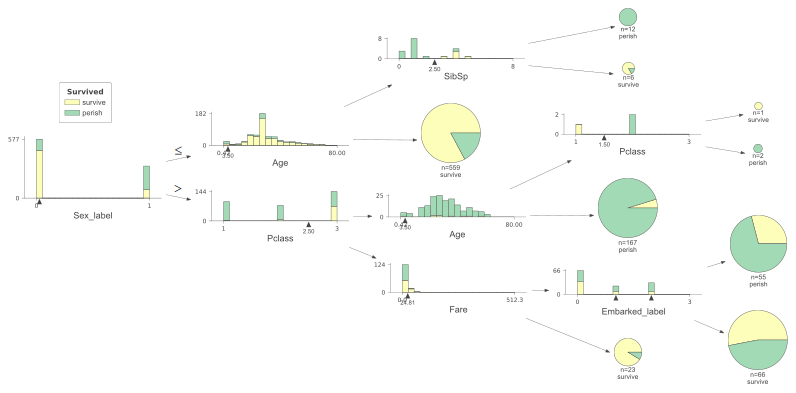

In [13]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

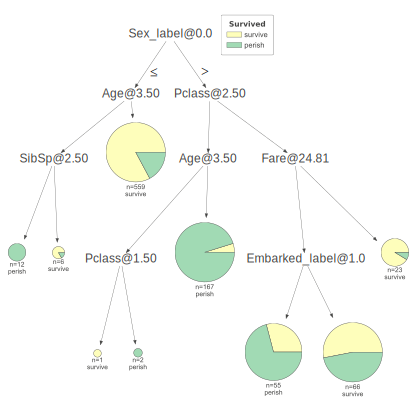

In [14]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

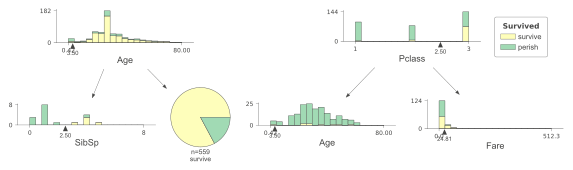

In [15]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [16]:
x = dataset[features].iloc[10]
x

Pclass             3.0
Sex_label          1.0
Embarked_label     0.0
Age                4.0
SibSp              1.0
Parch              1.0
Fare              16.7
Name: 10, dtype: float64

and then display the path through the tree structure:

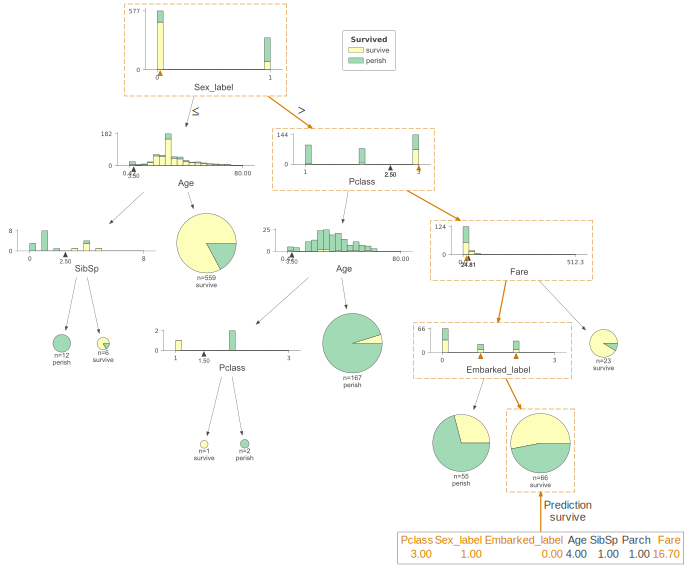

In [17]:
viz_model.view(x=x)

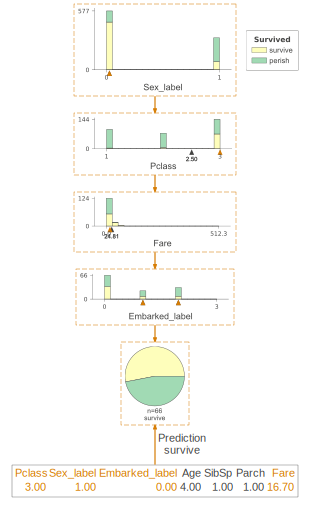

In [18]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [19]:
print(viz_model.explain_prediction_path(x))

2.5 <= Pclass 
Fare < 24.81
Embarked_label not in {1.0, 2.0}  
Sex_label not in {0.0}  



## Leaf info

There are a number of functions to get information about the leaves of the tree.

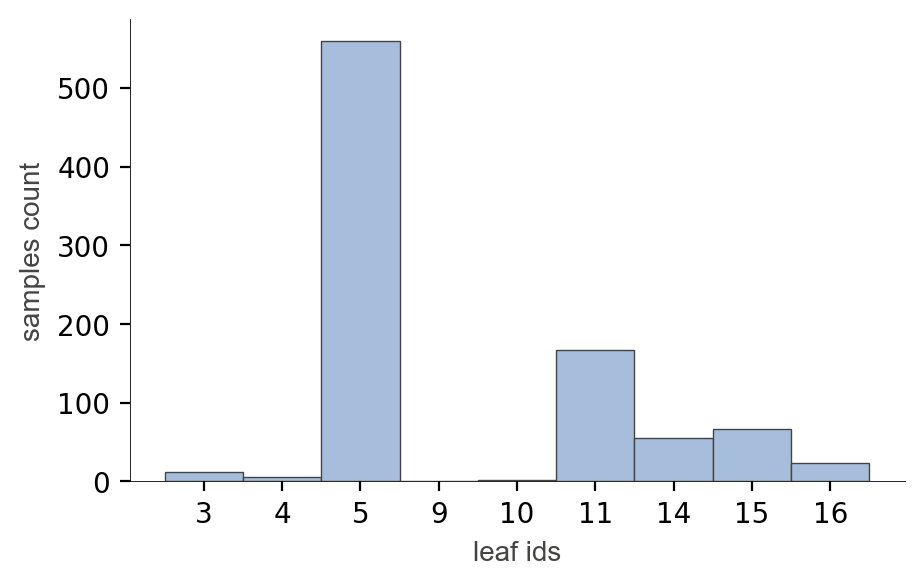

In [20]:
viz_model.leaf_sizes()

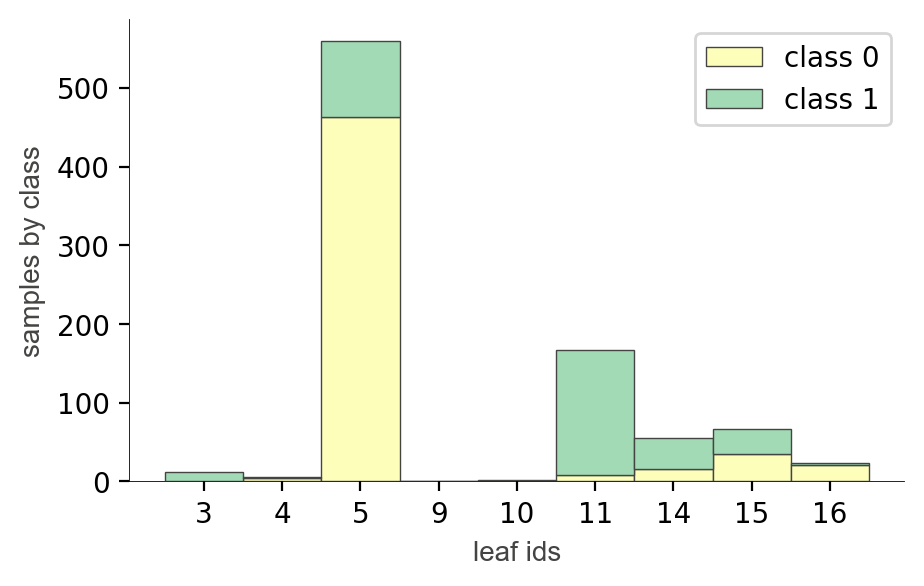

In [21]:
viz_model.ctree_leaf_distributions()

In [22]:
viz_model.node_stats(node_id=5)

Pclass  Sex_label  Embarked_label         Age       SibSp  \
count  559.000000      559.0      559.000000  559.000000  559.000000   
mean     2.388193        0.0        0.309481   31.436835    0.382826   
std      0.819522        0.0        0.597875   12.117992    1.005429   
min      1.000000        0.0        0.000000    4.000000    0.000000   
25%      2.000000        0.0        0.000000   24.000000    0.000000   
50%      3.000000        0.0        0.000000   29.699118    0.000000   
75%      3.000000        0.0        0.000000   36.000000    0.000000   
max      3.000000        0.0        2.000000   80.000000    8.000000   

            Parch        Fare  
count  559.000000  559.000000  
mean     0.200358   25.248440  
std      0.582849   43.463166  
min      0.000000    0.000000  
25%      0.000000    7.854200  
50%      0.000000   10.500000  
75%      0.000000   26.550000  
max      5.000000  512.329200

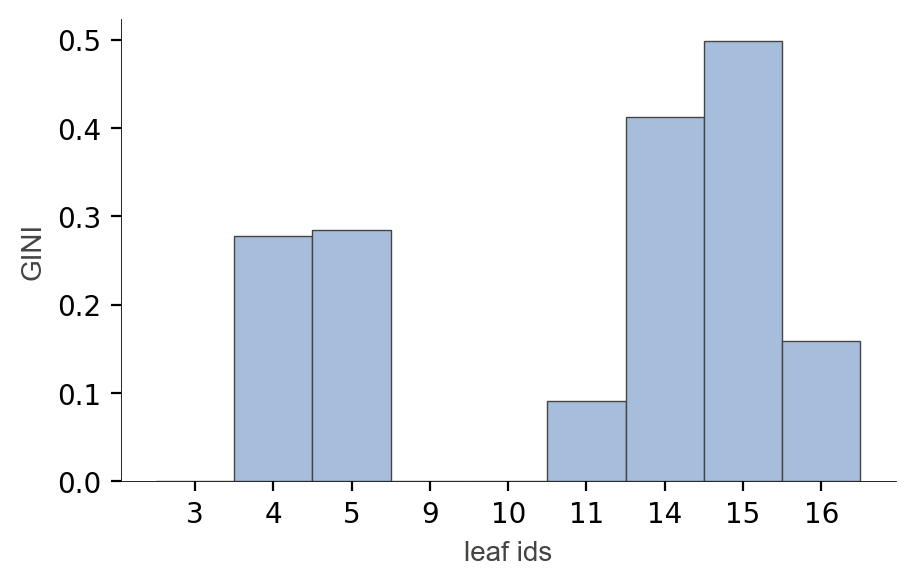

In [23]:
viz_model.leaf_purity()

# Regressors

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [24]:
features_reg = ["Pclass", "Fare", "Sex_label", "Embarked_label", "SibSp", "Parch", "Survived"]
target_reg = "Age"

vector_assembler_reg = VectorAssembler(inputCols=features_reg, outputCol="features_reg")
decision_tree_reg = DecisionTreeRegressor(featuresCol="features_reg", labelCol=target_reg, maxDepth=3, seed=1234)
pipeline_reg = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer, vector_assembler_reg, decision_tree_reg])
model_reg = pipeline_reg.fit(data)


## Initialize dtreeviz model (adaptor)

In [25]:
dataset_reg = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer]) \
    .fit(data) \
    .transform(data) \
    .toPandas()[features_reg + [target_reg]]

tree_model_regressor = model_reg.stages[4]


In [26]:
viz_rmodel = dtreeviz.model(tree_model_regressor,
                           X_train=dataset_reg[features_reg], y_train=dataset_reg[target_reg],
                           feature_names=features_reg,
                           target_name=target_reg)

## Tree structure visualisations

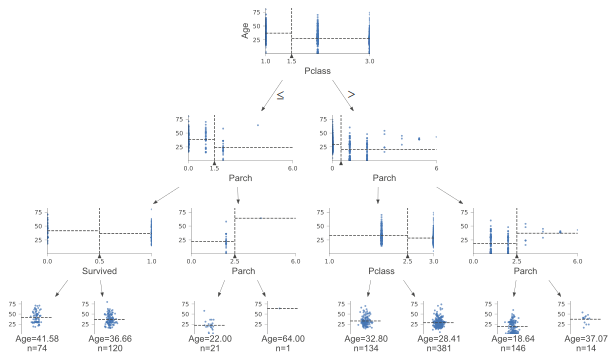

In [27]:
viz_rmodel.view()

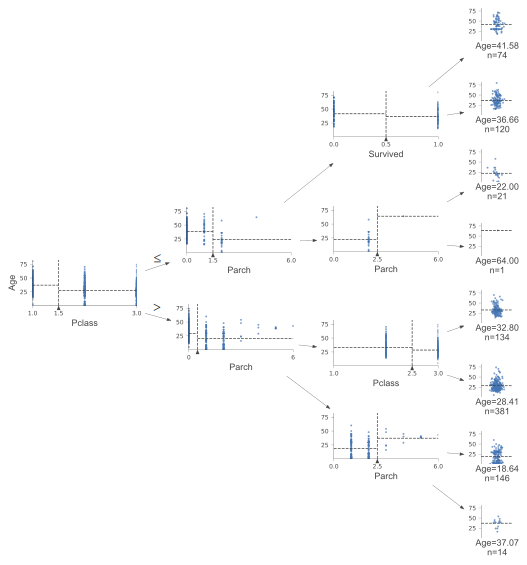

In [28]:
viz_rmodel.view(orientation="LR")

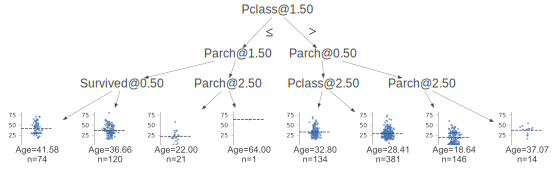

In [29]:
viz_rmodel.view(fancy=False)

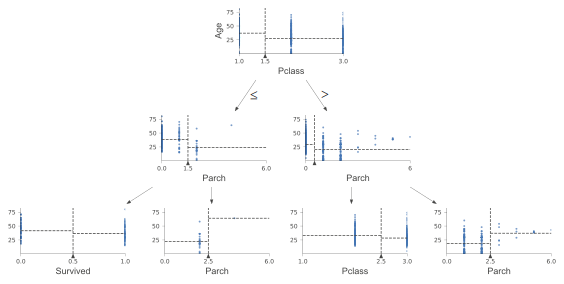

In [30]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations

In [31]:
x = dataset_reg[features_reg].iloc[10]
x

Pclass             3.0
Fare              16.7
Sex_label          1.0
Embarked_label     0.0
SibSp              1.0
Parch              1.0
Survived           1.0
Name: 10, dtype: float64

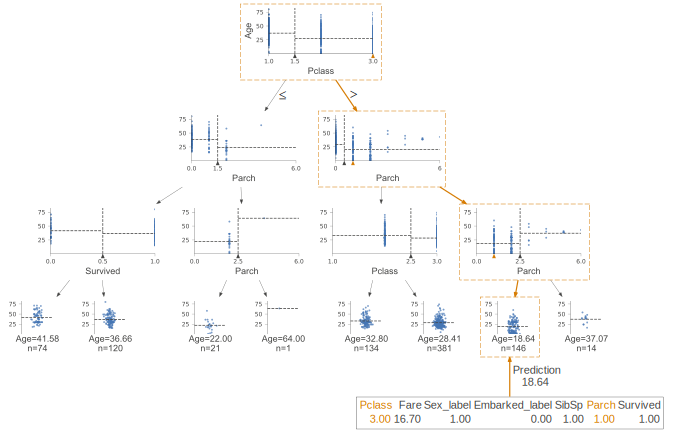

In [32]:
viz_rmodel.view(x = x)

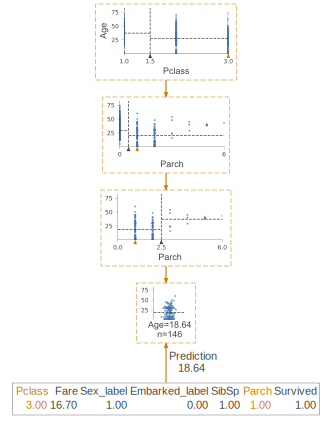

In [33]:
viz_rmodel.view(show_just_path=True, x = x)

In [34]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Pclass 
0.5 <= Parch  < 2.5



## Leaf info

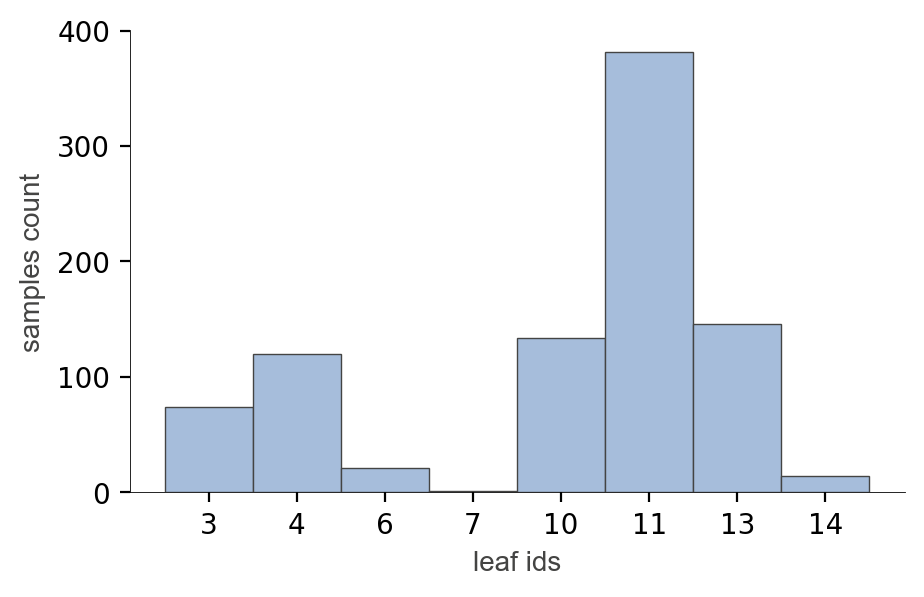

In [35]:
viz_rmodel.leaf_sizes()

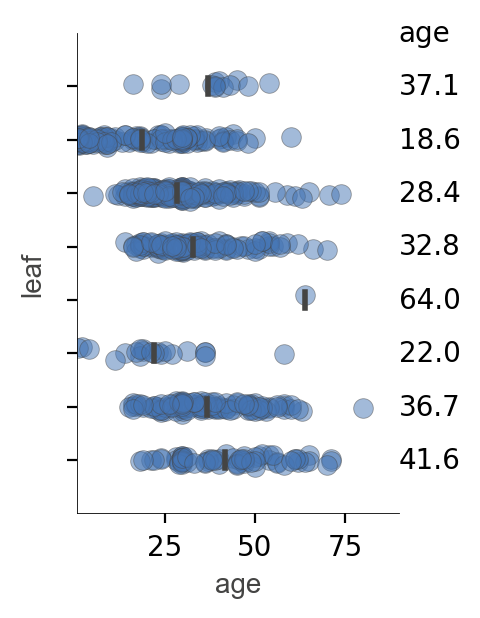

In [36]:
viz_rmodel.rtree_leaf_distributions()

In [37]:
viz_rmodel.node_stats(node_id=3)

Pclass        Fare  Sex_label  Embarked_label      SibSp      Parch  \
count    74.0   74.000000  74.000000       74.000000  74.000000  74.000000   
mean      1.0   54.335751   0.013514        0.351351   0.229730   0.135135   
std       0.0   47.559761   0.116248        0.508353   0.454725   0.344201   
min       1.0    0.000000   0.000000        0.000000   0.000000   0.000000   
25%       1.0   27.720800   0.000000        0.000000   0.000000   0.000000   
50%       1.0   39.050000   0.000000        0.000000   0.000000   0.000000   
75%       1.0   65.444800   0.000000        1.000000   0.000000   0.000000   
max       1.0  247.520800   1.000000        2.000000   2.000000   1.000000   

       Survived  
count      74.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

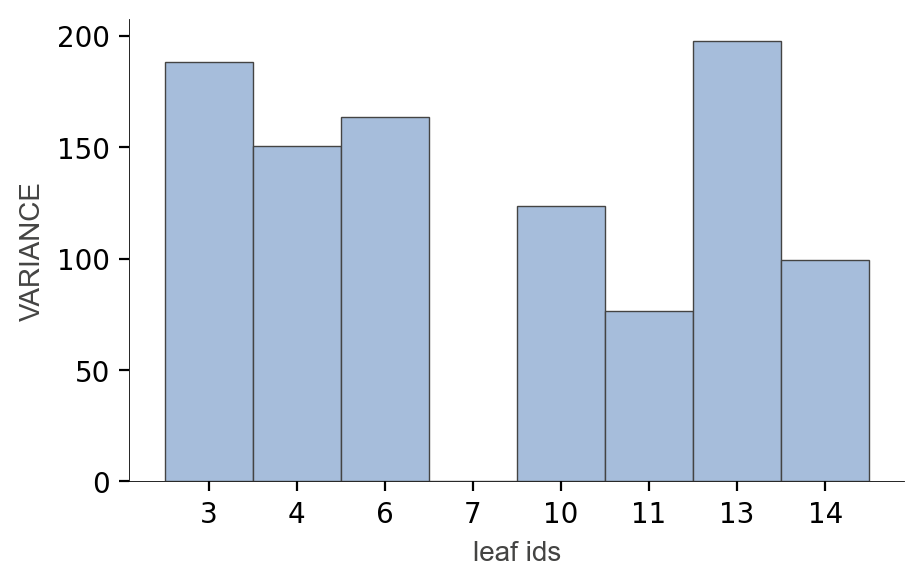

In [38]:
viz_rmodel.leaf_purity()

# Feature Space Partitioning

Decision trees partition feature space in such a way as to maximize target value purity for the instances associated with a node. It's often useful to visualize the feature space partitioning, although it's not feasible to visualize more than a couple of dimensions.

*work in progress for this library*

See [Feature Space Partitioning for scikit-learn](dtreeviz_sklearn_visualisations.ipynb#Feature_Space_Partitioning) for now.